## Fit gaussian profile to proton spatial beam
Mask the beam and fit a gaussian profile to extract beam pointing and width of the beam.  All measurements are in mm at the proton spatial screen.  After running the script, the output will be added to the protonSpatial database.  

An example of how to access information in the database is included at the end of this template.  

When using the template please make a copy first, add your initials to the end of the name e.g. _CP and then go ahead and play.
Contact Charlotte for any questions.

## Load in necessary packages

In [1]:
import numpy as np
from TA2HRR2021 import mirage_analysis, PKG_DATA
from TA2HRR2021.paths import DATA_FOLDER, CAL_DATA
from skimage.io import imread
from scipy.interpolate import RectBivariateSpline
mirage_analysis.configure(DATA_FOLDER)
# CAL_DATA = PKG_DATA
from TA2HRR2021.general_tools import choose_cal_file, glob_path, save_object, load_object, get_file_path, calc_COW
from scipy.ndimage import median_filter
from TA2HRR2021.image_analysis import Image_proc
from skimage.util import montage

from scipy.ndimage import gaussian_filter
import pathlib
from pathlib import Path
import pandas as pd
import os, re
import matplotlib.pyplot as plt
from TA2HRR2021.google_sheet import google_sheet_retrieval
from TA2HRR2021.general_tools import d, calc_COW, mad, generate_simplex, Read_SQL_shot_summary, get_file_shot_number

from TA2HRR2021.beam_fitting import fitBeam, gauss2Dbeam_img, gauss2Dbeam
import scipy.optimize as optimize
from scipy.interpolate import interp1d

from TA2HRR2021.analysis_database import Database

analysis_path = Path('/data/analysis/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/')

sql_reader = Read_SQL_shot_summary()

run_list = set(sql_reader.get_run_names())
run_list = sorted([x for x in run_list if 'run' in x])

my_fontsize = 14

In [5]:
print(PKG_DATA)

/opt/anaconda/envs/ta2/lib/python3.10/site-packages/TA2HRR2021/pkg_data


In [2]:
def dataframe_wrapper(df,run,burst=None,shot=None):
    if burst is None:
        sub_df = df.loc[run]
    elif shot is None:
        sub_df = df.loc[run,burst]
    else:
        sub_df = df.loc[run,burst,shot]
    return sub_df

In [3]:
def gauss2Dbeam(U,a0,a1,a2,a3,a4,a5):
    # a0 peak,
    # a2,a4 widths
    # a1,a3 centers
    # a5 angle
    X = U[0] -a1
    Y = U[1] -a3
    f = a0*np.exp( -(
        ( X*np.cos(a5)-Y*np.sin(a5))**2/(2*a2**2) + 
        ( X*np.sin(a5)+Y*np.cos(a5))**2/(2*a4**2) ) )

    return f

def threshold_mask(data,thresh=np.exp(-1),normalise_data=True,med_kernel=None):
    if med_kernel is not None:
        data = median_filter(data,med_kernel)
    if normalise_data:
        mask = data>=(thresh*np.nanmax(data))
    else:
        mask = data>=thresh
    return mask

def gauss2DbeamFit(pG,U,I,I_mask):

    f = gauss2Dbeam(U,*pG)
    f_mask = threshold_mask(f)
    fit_mask = ((f_mask+I_mask)>0)*screen_mask
    fErr = np.sqrt(np.mean(((f-I)**2)[I_mask]))
    return fErr

def fitBeam(x,y,img,beamMask,pGuess = (1,0,.1,0,.1,0),nonzdelt=5):
    
    (Ny,Nx) = np.shape(img)
    (X,Y) = np.meshgrid(x,y)
    XY = [X,Y]
    
    #(pFit,pcov) = sci.optimize.curve_fit(gauss2Dbeam, XY, I,p0=pGuess)
    a = (XY,img,beamMask)

    sim = generate_simplex(pGuess,nonzdelt = nonzdelt)
    z = optimize.minimize(gauss2DbeamFit,pGuess,args=a,method='Nelder-Mead',
                          options={ 'initial_simplex': sim, 
                            'xatol': 0.01, 'fatol': 1e-3, 'adaptive': True})
    pFit = z.x
    Ibeam = gauss2Dbeam(XY,*pFit)



    imgBeam = np.reshape(Ibeam,(Ny,Nx))
    return imgBeam, pFit


## Fitting functions

The workflow of the fit is presented here.  Given a run name and burst number these functions will prepare the data, run the fit and then allow you to access the coefficients.  

In [4]:
def fit_proton_spatial(run_name,burst_no):

    file_paths = get_file_path(diag,run_name,burst_no)

    pFit_list = []
    s_num_list = [get_file_shot_number(f) for f in file_paths]
    c_x_list = []
    c_y_list = []
    img_list = []
    for file_path in file_paths:
        #load and dewarp the images and create an array of images from one burst
        img = pSpatial_proc.file2screen(file_path)
        #select the nearly brightest pixel to avoid any hot pixels
        img_norm = np.percentile(img,99.99)
        #normalise the image to the maximum
        img = img/img_norm
        #set the threshold at 1/e of maximum
        img_thresh = np.exp(-1)
        #create a mask which includes all the data above the threshold and is modified by a screen mask.  Screen mask comes from the calibration file and should be loaded automatically given the run date. 
        fitMask = screen_mask*(img>img_thresh)
        #calculate the centre of weight of the masked image considering only the pixels above threshold
        c_x, c_y = calc_COW(img,X,Y,img_thresh=img_thresh)

        #used img_disp to show which part of the image were being used to calulate the centre of mass.  It's pretty restricted to the beam.
        img_disp = img>img_thresh

        #add the beam centre to a list of all the shots in the burst
        c_x_list.append(c_x)
        c_y_list.append(c_y)
        
        imgBeam, pFit = fitBeam(x_mm-c_x,y_mm-c_y,img,
                            fitMask,pGuess = np.array([1.0,0.0,5.0,0.0,5.0,0.0]), nonzdelt=5.0)
         
#         ### INSERT FILTERING HERE
#          #check signal to noise ratio
        fit_ok = check_SNR(img)
        if fit_ok:
#             print('fit ok:' + file_path)
            #             #2D gaussian fitting optimisation
            #make the fit parameters meaningful
            pFit[0] = pFit[0]*img_norm
            pFit[1] = pFit[1]+c_x
            pFit[3] = pFit[3]+c_y
            pFit = fix_params(pFit)
#             print(np.abs(pFit[2]/pFit[4]))
            if np.abs(pFit[2]/pFit[4])<0.2 or np.abs(pFit[2]/pFit[4])>5:
                pFit[0] = 0
                pFit[1] = 0
                pFit[2] = 0
                pFit[3] = 0
                pFit[4] = 0
                pFit[5] = 0
                
        else:
#             print('bad for fitting:' + file_path)
            pFit[0] = 0
            pFit[1] = 0
            pFit[2] = 0
            pFit[3] = 0
            pFit[4] = 0
            pFit[5] = 0
            


#         #2D gaussian fitting optimisation
#         imgBeam, pFit = fitBeam(x_mm-c_x,y_mm-c_y,img,
#                         fitMask,pGuess = np.array([1.0,0.0,5.0,0.0,5.0,0.0]), nonzdelt=5.0)
#         #make the fit parameters meaningful
#         pFit[0] = pFit[0]*img_norm
#         pFit[1] = pFit[1]+c_x
#         pFit[3] = pFit[3]+c_y
#         pFit = fix_params(pFit)

#         print(pFit)
        #add the fit parameters to a list 
        pFit_list.append(pFit)
        #add the normalised image to a list
        img_list.append(img*img_norm)
    return s_num_list, pFit_list, c_x_list, c_y_list, img_list


def fix_params(pFit):
    
    theta_mod = pFit[-1]/(np.pi/2)+0.5
    pFit[-1] = np.mod(theta_mod,1)*np.pi/2-np.pi/4
    if np.mod(theta_mod,2)>0:
        sx = np.abs(pFit[4])
        sy = np.abs(pFit[2])
    else:
        sx = np.abs(pFit[2])
        sy = np.abs(pFit[4])
    pFit[2] = sx
    pFit[4] = sy
    return pFit
        
def check_SNR(img):
    #calculate the standard deviation of the whole image
    img_std = np.std(img)
    img_median = np.median(img)
    
    #calculate the peak(ish) of the signal pixels
    img_norm = np.percentile(img,99.)
    
    
    #if peak of the signal isn't more than 4 times the standard deviation of the image then count as noise.
    if (img_norm >= (img_median + 4*img_std)) : #& (Perc_sig>=0.008):
        fittable = True
#         print(fittable)
    else:
        fittable = False
#         print(fittable)
        
    return fittable

## Setup which run you want to look at

In [36]:
diag = 'ProtonSpatial'

##run_name_cal - this point to the run name that has a calibration for the proton screen.  
##Typically you don't need to add this separately but I was trying to quickly run for a run date before our first calibration image.

# run_name_cal = '20210620/run10' #using this as the calibration wasn't available for the run i wanted to use.
run_name = '20210803/run23' 
run_name_cal = run_name

## other runs that have been used
# run_name = '20210603/run06'
#run_name = '20210620/run22'
#run_name = '20210618/run05'

#load calibration for dewarping of proton spatial
tForm_filepath = choose_cal_file(run_name_cal,1,diag,diag+'_transform',cal_data_path=PKG_DATA)

#create transform for the images using Image_proc.  The pSpatial_proc class can then be used for further analysis.
pSpatial_proc = Image_proc(tForm_filepath)
#create screen spatial axis and a x, y co-ordinate for each pixel.
x_mm = pSpatial_proc.screen_x_mm
y_mm = pSpatial_proc.screen_y_mm
X,Y = np.meshgrid(x_mm,y_mm)

# load a screen mask cased on run date.
screen_mask_file  = choose_cal_file(run_name,1,diag,diag+'_screen_mask',cal_data_path=PKG_DATA)
mask_data = load_object(screen_mask_file)
screen_mask = mask_data['screen_mask']

# make a database to store the proton spatial information.  
## NOTE: Overwrite is set to False so it won't overwrite existing data.  To do that change overwrite = True.
database_file = analysis_path / f'{diag}_results.pkl'
keys = ['COW_cx','COW_cy' ,'fit_peak','fit_cx','fit_sx','fit_cy','fit_sy','fit_theta']
db = Database(database_file,keys,always_load=True,overwrite=False)

#get the shot info from the database
shot_info = sql_reader.get_run(run_name)
shot_info.head()

,index,run,shot_or_burst,timestamp,burst_length
0,9572,20210803/run23,1,2021-08-03 18:03:37.501252,20.0
1,9573,20210803/run23,2,2021-08-03 18:03:53.906199,20.0
2,9574,20210803/run23,3,2021-08-03 18:04:10.501050,20.0
3,9575,20210803/run23,4,2021-08-03 18:04:27.083463,20.0
4,9576,20210803/run23,5,2021-08-03 18:04:43.706377,20.0


## Adding to the database
Note - this cell takes a long time as it runs over the whole run.

Loop over a run determining the 2D gaussian fit for each shot in the burst and adding it to the database

In [37]:
shot_info['shot_or_burst'].values

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype=object)

In [38]:
# burst_list = shot_info['shot_or_burst'].values[5:6]
# shot_list = [1]
# #loop over a run determining the fit for each shot in a burst and adding it to the database.
# for b,N_s in zip(burst_list,shot_list):
for b,N_s in zip(shot_info['shot_or_burst'],shot_info['burst_length']):
    if N_s is None:
        b=None
    elif not np.isfinite(N_s):
        b=None

#     #To analyse a particular burst use this if statement, for a whole run comment this out.
#     if int(b) != 5:
#         continue
        
    ## FIT THE BEAM AND ADD TO THE DATABASE
    pSpatial_shot, p_list, cx_list, cy_list,img_list = fit_proton_spatial(run_name,b)
    if pSpatial_shot: # check for empty list

    #['COW_cx','COW_cy' ,'fit_peak','fit_cx','fit_sx','fit_cy','fit_sy','fit_theta']
        data = [[cx,cy,*p] for cx,cy,p in zip(cx_list,cy_list,p_list)]
        if b is None:
            b=0
        indexes = [[run_name,int(b),int(s)] for s in pSpatial_shot]
        db.save_multiple_entries(indexes,data)

### Plotting the data from the run that was just calculated

this is just the last burst which is held inside img_list

In [86]:
print(len(img_list))

10


pFit: [ 1.30304854e+03 -9.54336020e+00  4.33411450e+00  2.21841822e+00
  9.81826160e+00  1.42906028e-01]


<ipython-input-23-f3922f62bf5e>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(x_mm, y_mm, img_list[n]*screen_mask*img_mask,vmax=img_thresh)
<ipython-input-23-f3922f62bf5e>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(x_mm, y_mm, img_beam*screen_mask*img_mask,vmax=img_thresh)


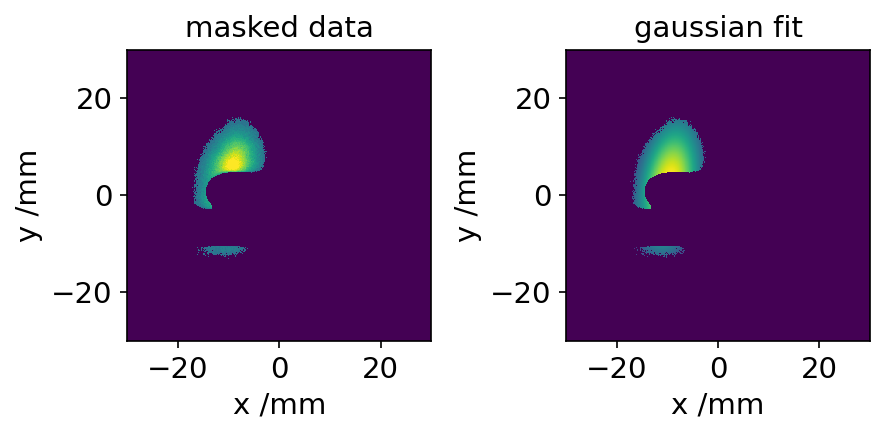

In [23]:
#select a shot
n = 1

#set up figure
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=150)
pFit = p_list[n]
print(f"pFit: {pFit}")

#create the gaussian beam profile based on the fit parameters
img_beam = gauss2Dbeam_img(X,Y,pFit,)
#normalise in the same way as the data
img_thresh = np.percentile(img_list[n],99.9)
img_mask = (img_list[n]>img_thresh*np.exp(-1))

#plot the raw data and the fit
axs[0].pcolormesh(x_mm, y_mm, img_list[n]*screen_mask*img_mask,vmax=img_thresh)
axs[1].pcolormesh(x_mm, y_mm, img_beam*screen_mask*img_mask,vmax=img_thresh)
title_list = ["masked data", "gaussian fit"]
for ax, title_str in zip(axs, title_list):
    ax.set_xlabel("x /mm", fontsize = my_fontsize)
    ax.set_ylabel("y /mm", fontsize = my_fontsize)
    ax.set_title(f"{title_str}", fontsize = my_fontsize)
    ax.tick_params(axis = 'both', labelsize=my_fontsize)
plt.tight_layout()

In [24]:
n = 5
pFit_temp = p_list[n]
s = 2
# print(f"pFit: {pFit_temp}")
# temp_df = df_wrapper(db.dataframe, run_name, int(b), int(s))
temp_df = dataframe_wrapper(db.dataframe, run_name, 5)
#         print(temp_df.values)
temp_df.head(200)
# df_values =  temp_df.values
# pFit = df_values
# print(f"pFit2: {pFit}")

,COW_cx,COW_cy,fit_cx,fit_cy,fit_peak,fit_sx,fit_sy,fit_theta
file_number,,,,,,,,
1,-10.6713,6.81101,-10.0799,3.1643,1350.99,4.11597,8.81364,0.0441177
2,-9.81883,6.4883,-9.54336,2.21842,1303.05,4.33411,9.81826,0.142906
3,-10.4714,5.32548,-10.3129,1.98906,1075.64,12.4499,5.02791,0.266199
4,-8.65231,7.59595,-8.65455,6.66152,1924.31,3.21523,4.71472,0.334607
5,-12.6046,5.28016,-11.9306,4.36398,1216.69,4.34387,6.18963,0.180951
...,...,...,...,...,...,...,...,...
96,4.03386,0.137139,3.97383,-0.58711,1061.78,13.4757,9.5975,0.452955
97,4.28594,-1.84653,3.6382,-1.80902,1286.25,14.0141,9.17545,0.482169
98,0.406428,2.09096,2.06412,1.40386,1688.4,12.7835,6.59281,0.528952


### Plotting all the data from the last run - careful this will be slow

In [25]:
#display functions for proton spatial with masking but no normalisation
def disp_proton_spatial(filepath):
    #load and dewarp the images and create an array of images from one burst
    img = pSpatial_proc.file2screen(file_path)
    #select the nearly brightest pixel to avoid any hot pixels
    img_norm = np.percentile(img,99.99)
    #normalise the image to the maximum
    img = img/img_norm
#     #set the threshold at 1/e of maximum
#     img_thresh = np.exp(-1)
#     #create a mask which includes all the data above the threshold and is modified by a screen mask.  Screen mask comes from the calibration file and should be loaded automatically given the run date. 
#     fitMask = screen_mask*(img>img_thresh)


#         #add the normalised image to a list
#         img_list.append(img*img_norm)

    return img*img_norm

#select a whole run or a burst from the dataframe
def df_wrapper(df,run,burst=None,shot=None):
    if burst is None:
        sub_df = df.loc[run]
    elif shot is None:
        sub_df = df.loc[run,burst]
    else:
        sub_df = df.loc[run,burst,shot]
    return sub_df

def pFit_extractor(df):
    #keys = ['COW_cx','COW_cy' ,'fit_peak','fit_cx','fit_sx','fit_cy','fit_sy','fit_theta']
    # [peak, center x, width x, centre y, width y, angle]
    pFit = []
    pFit.append(df['fit_peak'])
    pFit.append(df['fit_cx'])
    pFit.append(df['fit_sx'])
    pFit.append(df['fit_cy'])
    pFit.append(df['fit_sy'])
    pFit.append(df['fit_theta'])
    return pFit

In [41]:
new_directory = '//mnt/ceph/analysisdata/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/ProtonSpatial_Analysis/' + run_name + '/2DGaussianFit'
pathlib.Path(new_directory).mkdir(parents = True, exist_ok=True)
count = 0 
for b,N_s in zip(shot_info['shot_or_burst'],shot_info['burst_length']):
    if N_s is None:
        b=None
    elif not np.isfinite(N_s):
        b=None
    
    file_paths = get_file_path(diag,run_name,b)
    s_num_list = [get_file_shot_number(f) for f in file_paths]
    
    ## used for testing to limit time.
    if int(b) != 6 :
        continue
#     if int(b) > 1 :
#         break
    
    for s_num, file_path in zip(s_num_list, file_paths):
        
        
        
        
        img = disp_proton_spatial(file_path)
        temp_df = df_wrapper(db.dataframe, run_name, int(b), s_num)
        pFit = pFit_extractor(temp_df)
     
        #set up figure
        fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=150)

        

        #create the gaussian beam profile based on the fit parameters
        img_beam = gauss2Dbeam_img(X,Y,pFit,)
        #normalise in the same way as the data
        img_thresh = np.percentile(img,99.9)
        
        img_mask = (img>img_thresh*np.exp(-1))

        #plot the raw data and the fit
        axs[0].pcolormesh(x_mm, y_mm, img*screen_mask*img_mask,  vmin = 0 , vmax=img_thresh, shading = 'auto')
#         axs[1].pcolormesh(x_mm, y_mm, img_beam*screen_mask*img_mask, vmax=img_thresh)
        axs[1].pcolormesh(x_mm, y_mm, img_beam, vmin = 0, vmax=img_thresh, shading = 'auto')
  
        title_list = ["masked data", "gaussian fit"]
        for ax, title_str in zip(axs, title_list):
            ax.set_xlabel("x /mm", fontsize = my_fontsize)
            ax.set_ylabel("y /mm", fontsize = my_fontsize)
            ax.set_title(f"{title_str}", fontsize = my_fontsize)
            ax.tick_params(axis = 'both', labelsize=my_fontsize)
        plt.tight_layout()
        savename_plot = f'{new_directory}/Burst{b}_count{count}.png'
        plt.savefig(savename_plot)
        plt.close()
        count += 1

In [28]:
# build gif with the ordered files
import imageio
import glob
new_directory = '//mnt/ceph/analysisdata/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/ProtonSpatial_Analysis/' + run_name + '/2DGaussianFit'
pathlib.Path(new_directory).mkdir(parents = True, exist_ok=True)

filenames = glob.glob(f'{new_directory}/Burst5*.png')
filenames = sorted(filenames,key=lambda x: int((x.split("count")[1]).split(".")[0]))


for i in range(5):
    filenames.append(filenames[-1])

gifname = new_directory + '/mygif.gif'

with imageio.get_writer(gifname, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# # Remove files
# for filename in set(filenames):
#     os.remove(filename)

### Checking screen mask

<ipython-input-15-66ac7a3d5d7f>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x_mm, y_mm, screen_mask)


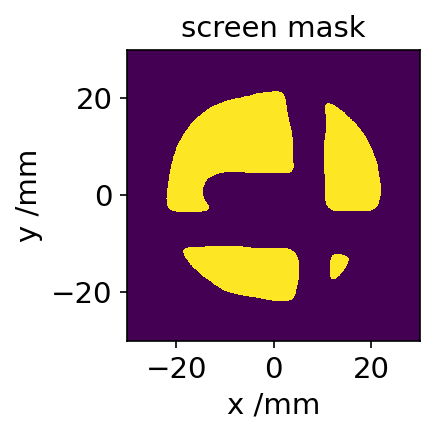

In [15]:
#set up figure
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
#plot the raw data and the fit

ax.pcolormesh(x_mm, y_mm, screen_mask)
title_str = "screen mask"

ax.set_xlabel("x /mm", fontsize = my_fontsize)
ax.set_ylabel("y /mm", fontsize = my_fontsize)
ax.set_title(f"{title_str}", fontsize = my_fontsize)
ax.tick_params(axis = 'both', labelsize=my_fontsize)
plt.tight_layout()

## Accessing the dataframe 

### Inspect the dataframe

In [6]:
#show saved dataframe (first 100 rows)
#centre of weight of raw image, centre of gaussian fit, maximum count of peak fit, sigma of fit, angle of fit (ellipsoid),
db.dataframe.head(100)

COW_cx     COW_cy    fit_cx      fit_cy  \
run            burst file_number                                              
20210603/run06 1     1            0.280068     -2.087    95.809     -115.08   
                     2            0.224682  -0.788496  -2230.11     1675.34   
                     3             1.61029 -0.0956257  -303.086     103.417   
                     4            0.694794   -1.41811   269.875    -461.262   
                     5             0.93556   0.375187   -12.442     -62.659   
...                                    ...        ...       ...         ...   
               10    6             2.70998   0.940708   3.68951      1.8057   
                     7            0.521391   -3.89513   3.75139    -2.56594   
                     8            -2.65255  -0.657607 -0.573149  0.00442673   
                     9             6.96589   0.427262   7.77768    -0.12905   
                     10           -1.26661   0.770045   20.9772    -48.8048   

                                 fit_peak   fit_sx   fit_sy fit_theta  
run            burst file_number                                       
20210603/run06 1     1            212.632  271.525  46.9832 -0.691161  
                     2            373.321  963.656  4148.39  0.257103  
                     3            209.962  61.4762  554.507  0.312062  
                     4            424.847  402.611  160.593 -0.466776  
                     5            183.146  102.245  363.787  0.645057  
...                                   ...      ...      ...       ...  
               10    6              443.8  16.6685  22.3577  0.558077  
                     7            483.162  22.8649   19.985 -0.289876  
                     8            634.676   17.556  20.7095  -0.16015  
                     9            779.552  30.6866  19.4109  0.158063  
                     10           167.076  166.027    60.97 -0.172442  

[100 rows x 8 columns]

### Plot the whole dataframe

Text(0, 0.5, 'beam width \\mm')

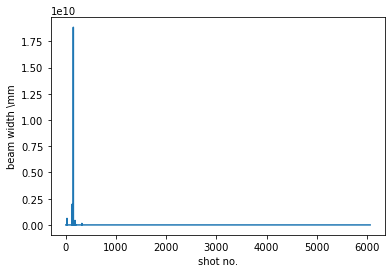

In [7]:
# plot the evolution of the beam width across the run.
plt.plot(db.dataframe['fit_sx'].values)
plt.xlabel('shot no.')
plt.ylabel('beam width \mm')
# plt.ylim([0,20])

## Load database and plot a burst or run

The burst structure is preserved by using the dataframe wrapper function below to specify a  whole run or a burst.

In [8]:
#select a whole run or a burst from the dataframe
def df_wrapper(df,run,burst=None,shot=None):
    if burst is None:
        sub_df = df.loc[run]
    elif shot is None:
        sub_df = df.loc[run,burst]
    else:
        sub_df = df.loc[run,burst,shot]
    return sub_df

Cell below shows an example of plotting a chosen run. 

NameError: name 'chosen_burst' is not defined

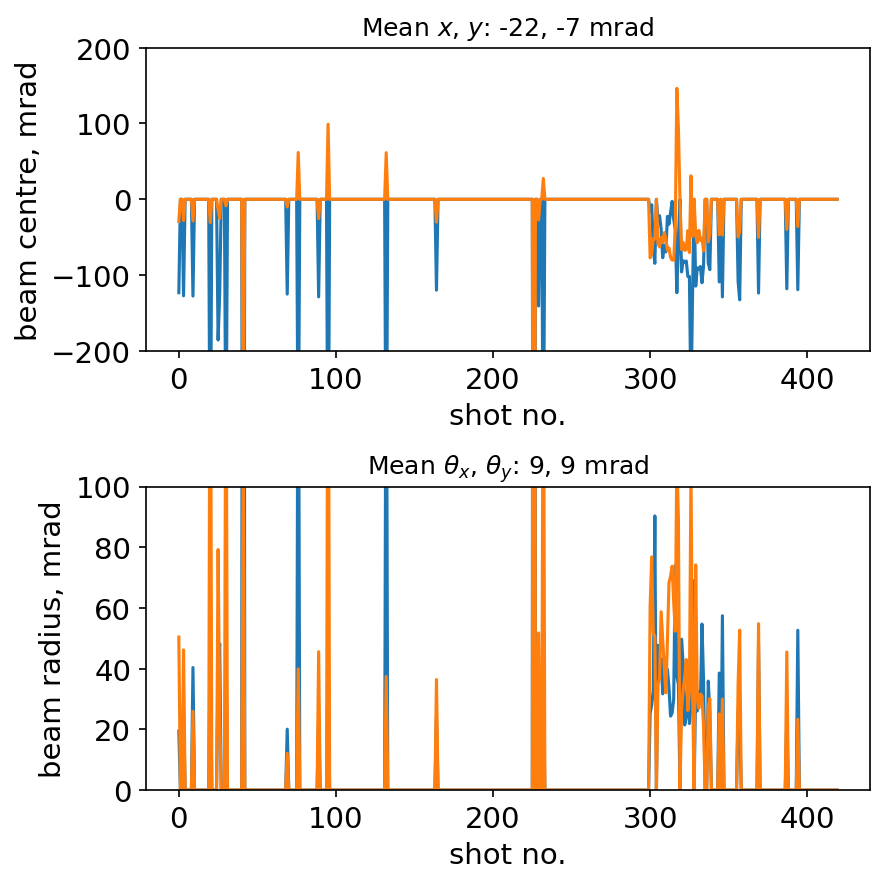

In [9]:
# use this cell to load data from a particular run or sub-burst
# del chosen_run_name, chosen_burst_num
#plot several bursts for comparison - divide by distance between source and screen (150 mm) and multiply by 1E3 to get mrad.
source_screen_distance_mm = 160
chosen_run_name = run_name
# chosen_burst = 4

temp_df = df_wrapper(db.dataframe, chosen_run_name)

MeanX = np.mean(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm)
MeanY = np.mean(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm)
StdX = np.std(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm)
StdY = np.std(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm)

AngleX = np.mean(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm)
AngleY = np.mean(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm)
StdAngleX = np.std(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm)
StdAngleY = np.std(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm)

# #select several consecutive bursts
# plotting_dfs = []
# for count in range(3):
#     chosen_burst = count
#     temp_df = df_wrapper(db.dataframe,chosen_run_name)
#     plotting_dfs.append(temp_df)
# result = pd.concat(plotting_dfs)
# for diag in diagList:
fig,axs = plt.subplots(2,1,figsize=(6, 6),dpi=150, tight_layout = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.28)

axs[0].plot(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm, label = f"x")
axs[0].plot(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm, label = f"y")
axs[0].set_ylabel("beam centre, mrad", fontsize = my_fontsize)  
axs[0].set_title(r"Mean $x$, $y$:" + f" {MeanX:.0f}, {MeanY:.0f} mrad")
axs[0].set_ylim([-200, 200])

axs[1].plot(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm, label = f"x")
axs[1].plot(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm, label = f"y")
axs[1].set_ylabel("beam radius, mrad", fontsize = my_fontsize)  
axs[1].set_title(r"Mean $\theta_x$, $\theta_y$:" + f" {AngleX:.0f}, {AngleY:.0f} mrad")
axs[1].set_ylim([0, 100])

for ax in axs:
    ax.set_xlabel("shot no.", fontsize = my_fontsize)
    ax.tick_params(axis = 'both', labelsize = my_fontsize)

plt.suptitle(f'{run_name}, burst {chosen_burst}', fontsize = my_fontsize)
lgd_x = 1
lgd_y = 0.5 

lgd = axs[1].legend(fontsize = my_fontsize-2, loc = 'center left', bbox_to_anchor = (lgd_x, lgd_y))
  


print(f"x-pointing: {np.mean(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm):.2f} mrad, std: {np.std(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm):.2f} mrad")
print(f"y-pointing: {np.mean(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm):.2f} mrad, std: {np.std(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm):.2f} mrad")
print(f"x-divergence: {np.mean(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm):.2f} mrad, std: {np.std(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm):.2f} mrad")
print(f"y-pointing: {np.mean(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm):.2f} mrad, std: {np.std(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm):.2f} mrad")

### The cell below is the same as the one above but with the data in two subplots

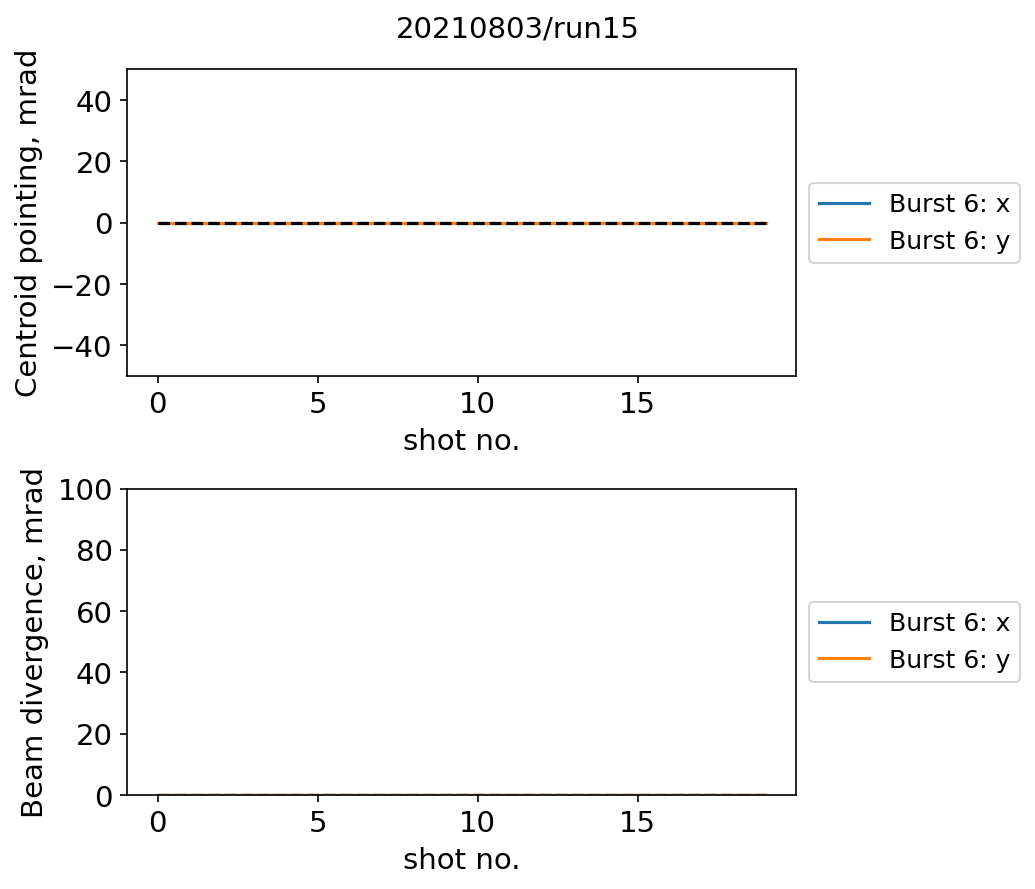

In [10]:
#plot several bursts for comparison - divide by distance between source and screen (150 mm) and multiply by 1E3 to get mrad.
source_screen_distance_mm = 160
chosen_run_name = run_name
fig,axs = plt.subplots(2,1,figsize=(7, 6),dpi=150, tight_layout = True)

#loop over the first 4 bursts
for count in np.arange(6,7):
    chosen_burst = count
    
    temp_df = df_wrapper(db.dataframe,chosen_run_name, chosen_burst)
    MeanX = np.median(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm)
    MeanY = np.median(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm)
    StdX = np.std(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm)
    StdY = np.std(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm)

    AngleX = np.median(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm)
    AngleY = np.median(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm)
    StdAngleX = np.std(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm)
    StdAngleY = np.std(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm)
    
    axs[0].plot(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm - MeanX, label = f"Burst {count}: x")
    axs[0].plot(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm - MeanY, label = f"Burst {count}: y")
    axs[0].plot(np.zeros_like(np.array(temp_df['fit_cx'].values)), 'k--')
    axs[1].plot(AngleX*np.ones_like(np.array(temp_df['fit_cx'].values)), 'k--')
    axs[1].plot(AngleY*np.ones_like(np.array(temp_df['fit_cx'].values)), 'k--')
    axs[1].plot(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm, label = f"Burst {count}: x")
    axs[1].plot(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm, label = f"Burst {count}: y")

    
axs[0].set_ylabel("Centroid pointing, mrad", fontsize = my_fontsize) 
axs[0].set_ylim([-50, 50])
axs[1].set_ylabel("Beam divergence, mrad", fontsize = my_fontsize)
axs[1].set_ylim([0, 100])
# plt.ylim([-100, 100])

for ax in axs:
    ax.set_xlabel("shot no.", fontsize = my_fontsize)
    ax.tick_params(axis = 'both', labelsize = my_fontsize)
    lgd_x = 1
    lgd_y = 0.5 
    lgd = ax.legend(fontsize = my_fontsize-2, loc = 'center left', bbox_to_anchor = (lgd_x, lgd_y))

    
th = plt.suptitle(f"{run_name}", fontsize = my_fontsize)
# plt.legend(fontsize = my_fontsize, loc = 'best')

# print(temp_db['fit_cx'].values)
# temp_df.head(100)
# db.dataframe.head()

run_str = run_name.replace('/','_')
#create directory for saving files
new_directory = '//mnt/ceph/analysisdata/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/ProtonSpatial_Analysis/' + run_name + '/ProtonPointing'
pathlib.Path(new_directory).mkdir(parents = True, exist_ok=True)
# plt.savefig(f'{new_directory}/MedianCorrectedPointing_{run_str}_burst_{count}.png',dpi=300, bbox_extra_artists = (lgd,th), bbox_inches = 'tight')
plt.savefig(f'{new_directory}/Pointing_Plus_Divergence_{run_str}_burst_{count}.png',dpi=300, bbox_extra_artists = (lgd,th), bbox_inches = 'tight')


### Another cell plotting different bursts together for comparison

Burst 4 - cx median: -7.701, cy median: -4.106, sx median: 288.947, sy median: 625.845
Burst 4 - cx rms: 78.496, cy rms: 17.448, sx rms: 288.947, sy rms: 1613.858
Burst 5 - cx median: 0.000, cy median: 0.000, sx median: 398.523, sy median: 505.383
Burst 5 - cx rms: 46.239, cy rms: 211.100, sx rms: 398.523, sy rms: 2947.065
Burst 6 - cx median: 0.000, cy median: 0.000, sx median: 32.376, sy median: 73.906
Burst 6 - cx rms: 26.441, cy rms: 18.081, sx rms: 32.376, sy rms: 352.559


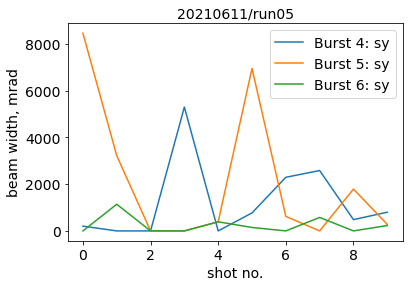

In [56]:
#plot several bursts for comparison - divide by distance between source and screen (150 mm) and multiply by 1E3 to get mrad.
for count in [4, 5, 6]:
    chosen_burst = count
    temp_df = df_wrapper(db.dataframe,chosen_run_name, chosen_burst)
#     plt.plot(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm, label = f"Burst {count}: sx")
    plt.plot(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm, label = f"Burst {count}: sy")
    print(f"Burst {count} - cx median: {np.median(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm):.3f}, cy median: {np.median(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm):.3f}, sx median: {np.median(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm):.3f}, sy median: {np.median(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm):.3f}")
    print(f"Burst {count} - cx rms: {mad(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm):.3f}, cy rms: {mad(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm):.3f}, sx rms: {mad(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm):.3f}, sy rms: {np.std(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm):.3f}")
    
# plt.ylim([0, 1000])
plt.xlabel("shot no.", fontsize = my_fontsize)
plt.ylabel("beam width, mrad", fontsize = my_fontsize)
plt.tick_params(axis = 'both', labelsize = my_fontsize)
plt.title(f"{run_name}", fontsize = my_fontsize)
plt.legend(fontsize = my_fontsize, loc = 'best')

The cell below shows how to plot the evolution of a value across the whole run

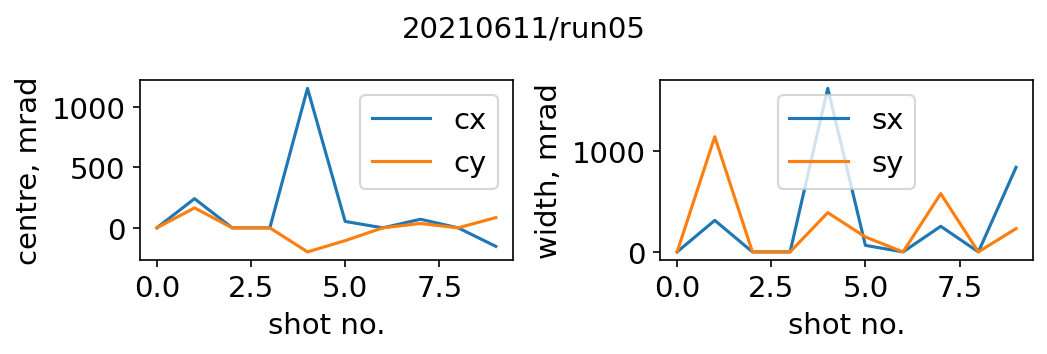

In [59]:
# plot the evolution of the beam width across the run - this is several bursts
fig, axs = plt.subplots(1,2, figsize = (18/2.54, 6/2.54), dpi = 150, tight_layout= True)
axs[0].plot(1E3*np.array(temp_df['fit_cx'].values)/source_screen_distance_mm, label = f"cx")
axs[0].plot(1E3*np.array(temp_df['fit_cy'].values)/source_screen_distance_mm, label = f"cy")
axs[1].plot(1E3*np.array(temp_df['fit_sx'].values)/source_screen_distance_mm, label = f"sx")
axs[1].plot(1E3*np.array(temp_df['fit_sy'].values)/source_screen_distance_mm, label = f"sy")
#axs[1].pcolormesh(x_rcf, y_rcf, image_rcf)

y_str_list = ["centre, mrad", "width, mrad"]
y_lim_list = [[-100, 100], [0, 200]]
for ax, y_str, y_lim in zip(axs,y_str_list, y_lim_list):
    ax.set_xlabel("shot no.", fontsize = my_fontsize)
    ax.set_ylabel(f"{y_str}", fontsize = my_fontsize)
    ax.tick_params(axis = 'both', labelsize = my_fontsize)
    ax.legend(fontsize = my_fontsize)
#     ax.set_ylim(y_lim)
# plt.ylim([-50, 125])
plt.suptitle(f"{run_name}", fontsize = my_fontsize)
plt.tight_layout()

In [ ]:
for count in [4, 5, 6]:
    chosen_burst = count
    temp_df = df_wrapper(db.dataframe,chosen_run_name, chosen_burst)